In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import io
import json
import time
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import the zstandard library to decompress the .zst file stream
try:
    import zstandard as zstd
except ImportError:
    !pip install zstandard
    import zstandard as zstd
    # Install and import graphviz for bonus visualization
try:
    import graphviz
except ImportError:
    !pip install graphviz
    import graphviz

# Set recursion depth higher for deep trees, especially the unbalanced BST
sys.setrecursionlimit(60000) # Sample size + buffer

print("Libraries imported successfully.")

# Helper class to store metrics for each operation
class OperationMetrics:
    def __init__(self):
        self.times = []
        self.heights = []
        self.rotations = [] # Specific to Treap

    def record(self, time_taken, height, rotations=0):
        self.times.append(time_taken)
        self.heights.append(height)
        if rotations > 0:
            self.rotations.append(rotations)

    def get_average_time(self):
        return np.mean(self.times) if self.times else 0

    def get_max_height(self):
        return np.max(self.heights) if self.heights else 0
    
    def get_total_rotations(self):
        return np.sum(self.rotations)

Libraries imported successfully.


**STEP 3- BST IMPLEMENTATION (ITERATIVE)**

In [2]:
# --- REVISED STEP 3: BST IMPLEMENTATION (ITERATIVE) ---

class BSTNode:
    """Node for the Binary Search Tree."""
    def __init__(self, postid, timestamp, score):
        self.postid = postid
        self.timestamp = timestamp
        self.score = score
        # The key for the BST is a tuple (timestamp, postid)
        self.key = (timestamp, postid) 
        self.left = None
        self.right = None
        self.parent = None # Useful for deletion
        self.height = 1

class BST:
    """
    Implementation of a standard Binary Search Tree (BST).
    [ROBUST VERSION]: This class uses ITERATIVE methods for
    add, delete, and traversal to prevent RecursionError on
    unbalanced trees (which is expected in this project).
    """
    def __init__(self):
        self.root = None
        # id_map provides fast O(1) average-case lookup by postid
        self.id_map = {}
        self.metrics = {
            'addPost': OperationMetrics(),
            'deletePost': OperationMetrics(),
            'likePost': OperationMetrics(),
            'getMostPopular': OperationMetrics(),
            'getMostRecent': OperationMetrics(),
        }

    def _get_height(self, node):
        return node.height if node else 0

    def _update_height(self, node):
        if node:
            node.height = 1 + max(self._get_height(node.left), self._get_height(node.right))

    # --- Core Operations (Iterative) ---

    def addPost(self, postid, timestamp, score):
        """Insert a post into BST, ordered by Timestamp (iterative)."""
        start_time = time.perf_counter()
        
        if postid in self.id_map:
            return 

        node = BSTNode(postid, timestamp, score)
        self.id_map[postid] = node
        
        if self.root is None:
            self.root = node
        else:
            # Iterative insertion
            current = self.root
            parent = None
            while current:
                parent = current
                if node.key < current.key:
                    current = current.left
                else:
                    current = current.right
            
            # Attach new node
            if node.key < parent.key:
                parent.left = node
            else:
                parent.right = node
            node.parent = parent
            
            # Update heights iteratively up the tree
            current = node
            while current:
                self._update_height(current)
                current = current.parent
            
        end_time = time.perf_counter()
        self.metrics['addPost'].record(end_time - start_time, self.get_height())

    def deletePost(self, postid):
        """Remove a post by ID (iterative)."""
        start_time = time.perf_counter()
        
        node_to_delete = self.id_map.pop(postid, None)
        if node_to_delete is None:
            end_time = time.perf_counter()
            self.metrics['deletePost'].record(end_time - start_time, self.get_height())
            return # Post not found

        parent = node_to_delete.parent
        node_to_update_height_from = None
        
        # Case 1: Node has no children (leaf)
        if node_to_delete.left is None and node_to_delete.right is None:
            if node_to_delete == self.root:
                self.root = None
            elif parent.left == node_to_delete:
                parent.left = None
            else:
                parent.right = None
            node_to_update_height_from = parent
            
        # Case 2: Node has one child (right)
        elif node_to_delete.left is None:
            child = node_to_delete.right
            if node_to_delete == self.root:
                self.root = child
                if child: child.parent = None
            elif parent.left == node_to_delete:
                parent.left = child
                if child: child.parent = parent
            else:
                parent.right = child
                if child: child.parent = parent
            node_to_update_height_from = parent

        # Case 2: Node has one child (left)
        elif node_to_delete.right is None:
            child = node_to_delete.left
            if node_to_delete == self.root:
                self.root = child
                if child: child.parent = None
            elif parent.left == node_to_delete:
                parent.left = child
                if child: child.parent = parent
            else:
                parent.right = child
                if child: child.parent = parent
            node_to_update_height_from = parent
                
        # Case 3: Node has two children
        else:
            # Find inorder successor (smallest in the right subtree)
            successor = self._find_min(node_to_delete.right)
            
            # Copy successor's data to the node
            node_to_delete.postid = successor.postid
            node_to_delete.timestamp = successor.timestamp
            node_to_delete.score = successor.score
            node_to_delete.key = successor.key
            
            # Update id_map to point to this node
            self.id_map[node_to_delete.postid] = node_to_delete
            
            # Now we need to delete the successor
            succ_parent = successor.parent
            succ_child = successor.right # Successor can't have a left child
            
            if succ_parent.left == successor:
                succ_parent.left = succ_child
            else:
                succ_parent.right = succ_child
                
            if succ_child:
                succ_child.parent = succ_parent
            
            node_to_update_height_from = succ_parent

        # Update heights iteratively up the tree
        current = node_to_update_height_from
        while current:
            self._update_height(current)
            current = current.parent
            
        end_time = time.perf_counter()
        self.metrics['deletePost'].record(end_time - start_time, self.get_height())


    def _find_min(self, node):
        current = node
        while current.left is not None:
            current = current.left
        return current

    # --- Required Functions (Iterative) ---

    def likePost(self, postid):
        """Increase the like count; does not affect structure."""
        start_time = time.perf_counter()
        
        node = self.id_map.get(postid)
        if node:
            node.score += 1
            
        end_time = time.perf_counter()
        self.metrics['likePost'].record(end_time - start_time, self.get_height())

    def getMostPopular(self):
        """Traverse the BST to find the post with the highest score count (iterative)."""
        start_time = time.perf_counter()
        
        if self.root is None:
            return None
        
        popular_node = self.root
        stack = [self.root]
        
        while stack:
            node = stack.pop()
            if node.score > popular_node.score:
                popular_node = node
            if node.left:
                stack.append(node.left)
            if node.right:
                stack.append(node.right)
                
        end_time = time.perf_counter()
        self.metrics['getMostPopular'].record(end_time - start_time, self.get_height())
        return (popular_node.postid, popular_node.timestamp, popular_node.score)

    def getMostRecent(self, k):
        """Return k-most recent posts (iterative reverse in-order traversal)."""
        start_time = time.perf_counter()
        
        recent_posts = []
        self._reverse_in_order(self.root, recent_posts, k)
        
        end_time = time.perf_counter()
        self.metrics['getMostRecent'].record(end_time - start_time, self.get_height())
        return recent_posts

    def _reverse_in_order(self, node, recent_posts, k):
        """Iterative helper for reverse in-order traversal."""
        stack = []
        current = node
        
        while (current or stack) and len(recent_posts) < k:
            # Go all the way to the right
            while current:
                stack.append(current)
                current = current.right
                
            # Pop the right-most node
            current = stack.pop()
            
            # Add it to the list
            recent_posts.append((current.postid, current.timestamp, current.score))
            
            # Move to the left child
            current = current.left

    # --- Metrics Functions ---
    
    def get_height(self):
        return self.root.height if self.root else 0

    def get_balancing_factor(self, node=None):
        if node is None:
            node = self.root
        if node is None:
            return 0
        return self._get_height(node.left) - self._get_height(node.right)
        
    def get_search_time(self, postid):
        start_time = time.perf_counter()
        node = self.id_map.get(postid)
        end_time = time.perf_counter()
        if node:
            return end_time - start_time
        return None

print("BST Implementation (Robust Iterative Version) Ready.")

BST Implementation (Robust Iterative Version) Ready.


**STEP 4- TREAPS**

In [3]:
class TreapNode:
    """Node for the Treap data structure."""
    def __init__(self, postid, timestamp, score):
        self.postid = postid
        self.timestamp = timestamp
        self.score = score
        # BST Key: (timestamp, postid)
        self.key = (timestamp, postid) 
        # Heap Priority: score
        self.priority = score 
        self.left = None
        self.right = None
        self.parent = None # Useful for rotations
        self.height = 1

class Treap:
    """
    Implementation of a Treap (Randomized BST).
    In this project, it's a 'Prioritized' BST where the 'priority'
    is explicitly set to the post 'score' to satisfy dual-ordering.
    Fulfills requirements of .
    
    - BST Property: on key = (timestamp, postid)
    - Heap Property: on priority = score (Max-Heap)
    """
    def __init__(self):
        self.root = None
        # id_map provides fast O(1) average-case lookup by postid
        self.id_map = {}
        self.rotation_count = 0
        self.metrics = {
            'addPost': OperationMetrics(),
            'deletePost': OperationMetrics(),
            'likePost': OperationMetrics(),
            'getMostPopular': OperationMetrics(),
            'getMostRecent': OperationMetrics(),
        }

    def _get_height(self, node):
        return node.height if node else 0

    def _update_height(self, node):
        if node:
            node.height = 1 + max(self._get_height(node.left), self._get_height(node.right))

    def _set_parent(self, child, parent):
        if child:
            child.parent = parent
            
    # --- Rotations (The core of the Treap) ---

    def _rotate_right(self, y):
        """
        Performs a right rotation at node y.
             y            x
            / \          / \
           x   T3  ---> T1  y
          / \              / \
         T1  T2           T2  T3
        """
        if not y or not y.left:
            return y
            
        self.rotation_count += 1
        x = y.left
        T2 = x.right
        
        # Perform rotation
        x.right = y
        y.left = T2
        
        # Update parents
        x.parent = y.parent
        self._set_parent(y, x)
        self._set_parent(T2, y)
        
        if x.parent is None:
            self.root = x
        elif x.parent.left == y:
            x.parent.left = x
        else:
            x.parent.right = x
            
        # Update heights
        self._update_height(y)
        self._update_height(x)
        
        return x

    def _rotate_left(self, x):
        """
        Performs a left rotation at node x.
           x            y
          / \          / \
         T1  y  --->  x   T3
            / \      / \
           T2  T3   T1  T2
        """
        if not x or not x.right:
            return x

        self.rotation_count += 1
        y = x.right
        T2 = y.left
        
        # Perform rotation
        y.left = x
        x.right = T2
        
        # Update parents
        y.parent = x.parent
        self._set_parent(x, y)
        self._set_parent(T2, x)
        
        if y.parent is None:
            self.root = y
        elif y.parent.left == x:
            y.parent.left = y
        else:
            y.parent.right = y
            
        # Update heights
        self._update_height(x)
        self._update_height(y)
        
        return y

    # --- Core Operations ---

    def addPost(self, postid, timestamp, score):
        """Insert a new post into the Treap."""
        start_time = time.perf_counter()
        
        if postid in self.id_map:
            return 

        node = TreapNode(postid, timestamp, score)
        self.id_map[postid] = node
        
        self.root = self._insert_node(self.root, node)
        
        end_time = time.perf_counter()
        # Record rotations *during* this operation
        rotations_before = self.rotation_count
        self._reheapify_up(node) # Bubble up to fix heap property
        op_rotations = self.rotation_count - rotations_before
        
        self.metrics['addPost'].record(end_time - start_time, self.get_height(), op_rotations)

    def _insert_node(self, root, node):
        """Recursive helper for insertion (BST part)."""
        if root is None:
            return node
        
        if node.key < root.key:
            root.left = self._insert_node(root.left, node)
            root.left.parent = root
        else:
            root.right = self._insert_node(root.right, node)
            root.right.parent = root
            
        self._update_height(root)
        return root

    def _reheapify_up(self, node):
        """Bubbles a node up to its correct position based on priority."""
        while node.parent and node.priority > node.parent.priority:
            if node == node.parent.left:
                self._rotate_right(node.parent)
            else:
                self._rotate_left(node.parent)
            
            # After rotation, node is the parent, so we check again
            if self.root == node:
                break 

    def deletePost(self, postid):
        """Remove a post by ID."""
        start_time = time.perf_counter()
        
        node = self.id_map.pop(postid, None)
        if not node:
            return 

        rotations_before = self.rotation_count
        
        # To delete, we rotate the node down to a leaf, then snip it.
        # We can do this by setting its priority to -infinity and bubbling down.
        node.priority = -float('inf')
        self._reheapify_down(node)
        
        # Now the node is a leaf (or close to it), so we can delete it
        # using standard BST deletion, which is simpler at a leaf.
        self.root = self._delete_bst_node(self.root, node.key)
        
        op_rotations = self.rotation_count - rotations_before
        end_time = time.perf_counter()
        self.metrics['deletePost'].record(end_time - start_time, self.get_height(), op_rotations)

    def _reheapify_down(self, node):
        """Bubbles a node down to its correct position."""
        while True:
            max_child = None
            if node.left and node.right:
                max_child = node.left if node.left.priority > node.right.priority else node.right
            elif node.left:
                max_child = node.left
            elif node.right:
                max_child = node.right
            else:
                break # Node is a leaf
                
            if node.priority < max_child.priority:
                if max_child == node.left:
                    self._rotate_right(node)
                else:
                    self._rotate_left(node)
                if self.root == max_child:
                    self.root = max_child
            else:
                break # Heap property satisfied

    def _delete_bst_node(self, root, key):
        """
        Standard BST delete, simplified because we've rotated the node
        to be a leaf (or have one child).
        """
        if root is None:
            return None
        
        if key < root.key:
            root.left = self._delete_bst_node(root.left, key)
            if root.left: root.left.parent = root
        elif key > root.key:
            root.right = self._delete_bst_node(root.right, key)
            if root.right: root.right.parent = root
        else:
            # This is the node to delete
            if root.left is None:
                return root.right
            elif root.right is None:
                return root.left
            
            # This case (2 children) shouldn't happen often
            # if we've reheapified down, but we handle it.
            temp = self._find_min(root.right)
            root.postid = temp.postid
            root.timestamp = temp.timestamp
            root.score = temp.score
            root.key = temp.key
            root.priority = temp.priority
            self.id_map[root.postid] = root
            root.right = self._delete_bst_node(root.right, temp.key)

        if root:
            self._update_height(root)
        return root

    def _find_min(self, node):
        current = node
        while current.left is not None:
            current = current.left
        return current


    # --- Required Functions  ---

    def likePost(self, postid):
        """Increase the like count; reheapify to maintain heap property."""
        start_time = time.perf_counter()
        
        node = self.id_map.get(postid)
        if node:
            node.score += 1
            node.priority = node.score
            rotations_before = self.rotation_count
            self._reheapify_up(node)
            op_rotations = self.rotation_count - rotations_before
        
        end_time = time.perf_counter()
        self.metrics['likePost'].record(end_time - start_time, self.get_height(), op_rotations)

    def getMostPopular(self):
        """Return post with highest popularity (max-heap root)."""
        start_time = time.perf_counter()
        
        # This is O(1) for a Treap, a major advantage
        popular_node = self.root
        
        end_time = time.perf_counter()
        self.metrics['getMostPopular'].record(end_time - start_time, self.get_height())
        
        if popular_node:
            return (popular_node.postid, popular_node.timestamp, popular_node.score)
        return None

    def getMostRecent(self, k):
        """Return k-most recent posts (reverse in-order traversal)."""
        # This is identical to the BST's implementation
        start_time = time.perf_counter()
        
        recent_posts = []
        self._reverse_in_order(self.root, recent_posts, k)
        
        end_time = time.perf_counter()
        self.metrics['getMostRecent'].record(end_time - start_time, self.get_height())
        return recent_posts

    def _reverse_in_order(self, node, recent_posts, k):
        """Helper for reverse in-order traversal."""
        if node is None or len(recent_posts) >= k:
            return
        
        self._reverse_in_order(node.right, recent_posts, k)
        
        if len(recent_posts) < k:
            recent_posts.append((node.postid, node.timestamp, node.score))
        
        if len(recent_posts) < k:
            self._reverse_in_order(node.left, recent_posts, k)

    # --- Metrics Functions [cite: 43, 44] ---
    
    def get_height(self):
        """Returns the height of the tree."""
        return self.root.height if self.root else 0

    def get_balancing_factor(self, node=None):
        """Calculates the balance factor of a node (height(L) - height(R))."""
        if node is None:
            node = self.root
        if node is None:
            return 0
        return self._get_height(node.left) - self._get_height(node.right)

    def get_search_time(self, postid):
        """Measures time to find a node by ID (using the map)."""
        start_time = time.perf_counter()
        node = self.id_map.get(postid)
        end_time = time.perf_counter()
        if node:
            return end_time - start_time
        return None
    #
# --- BONUS IMPLEMENTATION METHODS ---
#

    def _split(self, root, key):
        """
        BONUS: Splits the Treap into two Treaps (L, R)
        L contains all keys <= key
        R contains all keys > key
        """
        if root is None:
            return None, None

        if root.key <= key:
            # Current root and its left subtree go to L
            L, R = self._split(root.right, key)
            root.right = L
            if L: L.parent = root
            self._update_height(root)
            return root, R
        else:
            # Current root and its right subtree go to R
            L, R = self._split(root.left, key)
            root.left = R
            if R: R.parent = root
            self._update_height(root)
            return L, root

    def union(self, other_treap):
        """
        BONUS: Merges this Treap with another Treap.
        """
        self.root = self._merge(self.root, other_treap.root)
        # This implementation doesn't merge id_maps,
        # so it's primarily for structural union.
        # A full union would require merging id_maps as well.

    def _merge(self, L, R):
        """
        BONUS: Merges two Treaps L and R, assuming all keys in L
        are less than all keys in R. (This is a simplified merge)
        """
        if L is None: return R
        if R is None: return L

        if L.priority > R.priority:
            # L's root becomes the new root
            L.right = self._merge(L.right, R)
            if L.right: L.right.parent = L
            self._update_height(L)
            return L
        else:
            # R's root becomes the new root
            R.left = self._merge(L, R.left)
            if R.left: R.left.parent = R
            self._update_height(R)
            return R

    def visualize(self):
        """
        BONUS: Generates a Graphviz visualization of the tree.
        """
        dot = graphviz.Digraph(comment='Treap')

        def add_nodes_edges(node):
            if node:
                # Node(key, priority)
                dot.node(str(node.key), f"id: {node.postid}\n(score: {node.priority})")
                if node.left:
                    dot.edge(str(node.key), str(node.left.key), label='L')
                    add_nodes_edges(node.left)
                if node.right:
                    dot.edge(str(node.key), str(node.right.key), label='R')
                    add_nodes_edges(node.right)

        add_nodes_edges(self.root)
        return dot
#
# --- END OF BONUS METHODS ---
#

print("Treap Implementation Ready.")

Treap Implementation Ready.


**STEP 5- THE 4 TEST CASES**

In [4]:
# CORRECT VERSION
def print_tree(node, prefix="", is_left=True):
    """A simple utility to print the tree structure."""
    if not node:
        print(prefix + ("└── " if is_left else "┌── ") + "None")
        return

    if node.right:
        print_tree(node.right, prefix + ("│   " if is_left else "    "), False) # <--- FIX HERE
    
    print(prefix + ("└── " if is_left else "┌── ") + f"id:{node.postid} (ts:{node.timestamp}, score:{node.score})")
    
    if node.left:
        print_tree(node.left, prefix + ("    " if is_left else "│   "), True)

# --- Run the Test Case  ---
print("--- Running Test Case  ---")
test_treap = Treap()

# 1. Add posts [cite: 49-54]
print("\n--- 1. Adding 5 posts ---")
test_treap.addPost("ejualnb", 1554076800, 55)
test_treap.addPost("ejualnc", 1554076800, 12)
test_treap.addPost("ejualnd", 1554076800, 27)
test_treap.addPost("ejualne", 1554076800, 14)
test_treap.addPost("ejualnl", 1554076809, 13) # Note: different timestamp

print_tree(test_treap.root)

# 2. Like the post 'ejualnl' 2 times [cite: 55-57]
print("\n--- 2. Liking post 'ejualnl' twice ---")
test_treap.likePost('ejualnl') # score becomes 14
test_treap.likePost('ejualnl') # score becomes 15
print_tree(test_treap.root)

# 3. Delete the post 'ejualnc' [cite: 58-59]
print("\n--- 3. Deleting post 'ejualnc' ---")
test_treap.deletePost('ejualnc')
print_tree(test_treap.root)

# 4. Get the most popular post [cite: 60-61]
print("\n--- 4. Getting most popular post ---")
most_popular = test_treap.getMostPopular()
print(f"getMostPopular() ----> {most_popular}")

# Verification:
expected_popular = ('ejualnb', 1554076800, 55)
if most_popular == expected_popular:
    print("Test Case PASSED: getMostPopular() is correct.")
else:
    print(f"Test Case FAILED: Expected {expected_popular} but got {most_popular}")

--- Running Test Case  ---

--- 1. Adding 5 posts ---
│           ┌── id:ejualnl (ts:1554076809, score:13)
│       ┌── id:ejualne (ts:1554076800, score:14)
│   ┌── id:ejualnd (ts:1554076800, score:27)
│   │   └── id:ejualnc (ts:1554076800, score:12)
└── id:ejualnb (ts:1554076800, score:55)

--- 2. Liking post 'ejualnl' twice ---
│       ┌── id:ejualnl (ts:1554076809, score:15)
│       │   └── id:ejualne (ts:1554076800, score:14)
│   ┌── id:ejualnd (ts:1554076800, score:27)
│   │   └── id:ejualnc (ts:1554076800, score:12)
└── id:ejualnb (ts:1554076800, score:55)

--- 3. Deleting post 'ejualnc' ---
│       ┌── id:ejualnl (ts:1554076809, score:15)
│       │   └── id:ejualne (ts:1554076800, score:14)
│   ┌── id:ejualnd (ts:1554076800, score:27)
└── id:ejualnb (ts:1554076800, score:55)

--- 4. Getting most popular post ---
getMostPopular() ----> ('ejualnb', 1554076800, 55)
Test Case PASSED: getMostPopular() is correct.


**BONUS VISUALIZATION**


--- Bonus Visualization of Test Treap ---


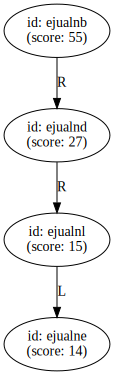

In [5]:
# --- STEP 8: RUNNING THE BONUS VISUALIZATION ---

# We use the 'test_treap' object created in Step 5
# Make sure Step 5 has been run first!
if 'test_treap' in locals():
    print("\n--- Bonus Visualization of Test Treap ---")
    dot_graph = test_treap.visualize()
    if dot_graph:
        display(dot_graph)
else:
    print("Please run Step 5 (Test Case) first to create 'test_treap'.")

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/the-pushshift-reddit-dataset-submissions/RC_2019-04.zst


**STEP 6- THE MAIN EXPERIMENT**

In [6]:
# --- Dataset Streaming and Handling [cite: 24-30] ---

# !!! IMPORTANT !!!
# Update this path to the .zst file you added to your notebook
DATA_FILE_PATH = "/kaggle/input/the-pushshift-reddit-dataset-submissions/RC_2019-04.zst"

def stream_reddit_data(file_path, max_records=None):
    """
    Streams and yields records from the compressed .zst JSON-lines file.
    This implements the 'Stream Processing in Compressed Form' strategy.
    """
    count = 0
    try:
        with open(file_path, 'rb') as f:
            dctx = zstd.ZstdDecompressor()
            with dctx.stream_reader(f) as reader:
                text_stream = io.TextIOWrapper(reader, encoding='utf-8')
                for line in text_stream:
                    if max_records and count >= max_records:
                        break
                    try:
                        record = json.loads(line)
                        # We only care about the keys specified in the project [cite: 23]
                        if 'id' in record and 'created_utc' in record and 'score' in record:
                            yield (record['id'], int(record['created_utc']), int(record['score']))
                            count += 1
                    except (json.JSONDecodeError, KeyError, TypeError):
                        # Skip malformed lines or records missing keys
                        continue
    except FileNotFoundError:
        print(f"ERROR: Data file not found at {file_path}")
        print("Please update DATA_FILE_PATH in this cell.")
        return
    except Exception as e:
        print(f"An error occurred during streaming: {e}")
        return

# --- Ablation Study / Experiment Runner  ---

print("Starting experiment...")
print("This may take several minutes depending on the SAMPLE_SIZE.")

# Parameters for the experiment
SAMPLE_SIZE = 50000  # Number of posts to insert
OPS_SAMPLE_SIZE = 5000 # Number of like/delete/search ops to test

# Initialize our two data structures
bst = BST()
treap = Treap()

# Store all post IDs we add, so we can sample them for like/delete
post_ids = []

# 1. --- Insertion Test ---
print(f"--- 1. Testing addPost() for {SAMPLE_SIZE} posts ---")
data_stream = stream_reddit_data(DATA_FILE_PATH, max_records=SAMPLE_SIZE)

for post_id, timestamp, score in data_stream:
    if post_id not in bst.id_map: # Avoid duplicates
        bst.addPost(post_id, timestamp, score)
        treap.addPost(post_id, timestamp, score)
        post_ids.append(post_id)

print(f"Insertion test complete. {len(post_ids)} unique posts added.")
if not post_ids:
    print("ERROR: No data was loaded. Check DATA_FILE_PATH.")
else:
    # 2. --- likePost, deletePost, Search Test ---
    print(f"--- 2. Testing {OPS_SAMPLE_SIZE} likePost/deletePost/search ops ---")
    
    # Get a random sample of IDs to operate on
    sample_ids_for_ops = random.sample(post_ids, min(len(post_ids), OPS_SAMPLE_SIZE))
    
    # --- Search Time Metric ---
    # This is a bit special. We'll measure it separately.
    bst_search_times = []
    treap_search_times = []
    
    # --- likePost and getMostPopular Test ---
    for post_id in sample_ids_for_ops:
        bst.likePost(post_id)
        treap.likePost(post_id)
        
        # Test getMostPopular every 50 likes
        if sample_ids_for_ops.index(post_id) % 50 == 0:
            bst.getMostPopular()
            treap.getMostPopular()
        
        # --- Search Time (avg) [cite: 44] ---
        bst_search_times.append(bst.get_search_time(post_id))
        treap_search_times.append(treap.get_search_time(post_id))

    # --- getMostRecent Test ---
    bst.getMostRecent(10)
    treap.getMostRecent(10)
    
    # --- Deletion Test ---
    # We use a *different* sample to ensure we're not deleting
    # posts we just liked (though that would be a valid test too)
    sample_ids_for_delete = random.sample(post_ids, min(len(post_ids), OPS_SAMPLE_SIZE))
    
    for post_id in sample_ids_for_delete:
        if post_id in bst.id_map: # Ensure it wasn't already deleted
            bst.deletePost(post_id)
            treap.deletePost(post_id)

    print("--- Experiment Finished ---")

    # --- 3. Collect Final Metrics ---
    print("\n--- Final Metrics Summary ---")
    
    metrics_data = {
        'Metric': [
            'Insertion Time (avg)', 
            'Deletion Time (avg)',
            'likePost Time (avg)',
            'getMostPopular Time (avg)',
            'getMostRecent(10) Time (avg)',
            'Search Time (avg)',
            'Final Height of the Tree',
            'Final Balancing Factor (Root)',
            'Total Rotations'
        ],
        'Treap': [
            treap.metrics['addPost'].get_average_time(),
            treap.metrics['deletePost'].get_average_time(),
            treap.metrics['likePost'].get_average_time(),
            treap.metrics['getMostPopular'].get_average_time(),
            treap.metrics['getMostRecent'].get_average_time(),
            np.mean(treap_search_times),
            treap.get_height(),
            treap.get_balancing_factor(),
            treap.rotation_count
        ],
        'Binary Search Tree (BST)': [
            bst.metrics['addPost'].get_average_time(),
            bst.metrics['deletePost'].get_average_time(),
            bst.metrics['likePost'].get_average_time(),
            bst.metrics['getMostPopular'].get_average_time(),
            bst.metrics['getMostRecent'].get_average_time(),
            np.mean(bst_search_times),
            bst.get_height(),
            bst.get_balancing_factor(),
            0 # BSTs don't rotate
        ]
    }
    
    # Create a DataFrame for easy viewing
    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df.to_string()) # .to_string() prints the full table

Starting experiment...
This may take several minutes depending on the SAMPLE_SIZE.
--- 1. Testing addPost() for 50000 posts ---
Insertion test complete. 50000 unique posts added.
--- 2. Testing 5000 likePost/deletePost/search ops ---
--- Experiment Finished ---

--- Final Metrics Summary ---
                          Metric         Treap  Binary Search Tree (BST)
0           Insertion Time (avg)  2.219747e-05              1.556916e-02
1            Deletion Time (avg)  4.746305e-05              1.272149e-02
2            likePost Time (avg)  2.321262e-06              9.710968e-07
3      getMostPopular Time (avg)  3.653300e-07              9.033319e-03
4   getMostRecent(10) Time (avg)  1.604200e-05              9.642126e-03
5              Search Time (avg)  2.689036e-07              3.486592e-07
6       Final Height of the Tree  3.800000e+01              4.468800e+04
7  Final Balancing Factor (Root) -1.000000e+01             -4.468700e+04
8                Total Rotations  6.192500e+04    

**COMPARISON VISUALIZATIONS**

Generating visualizations...


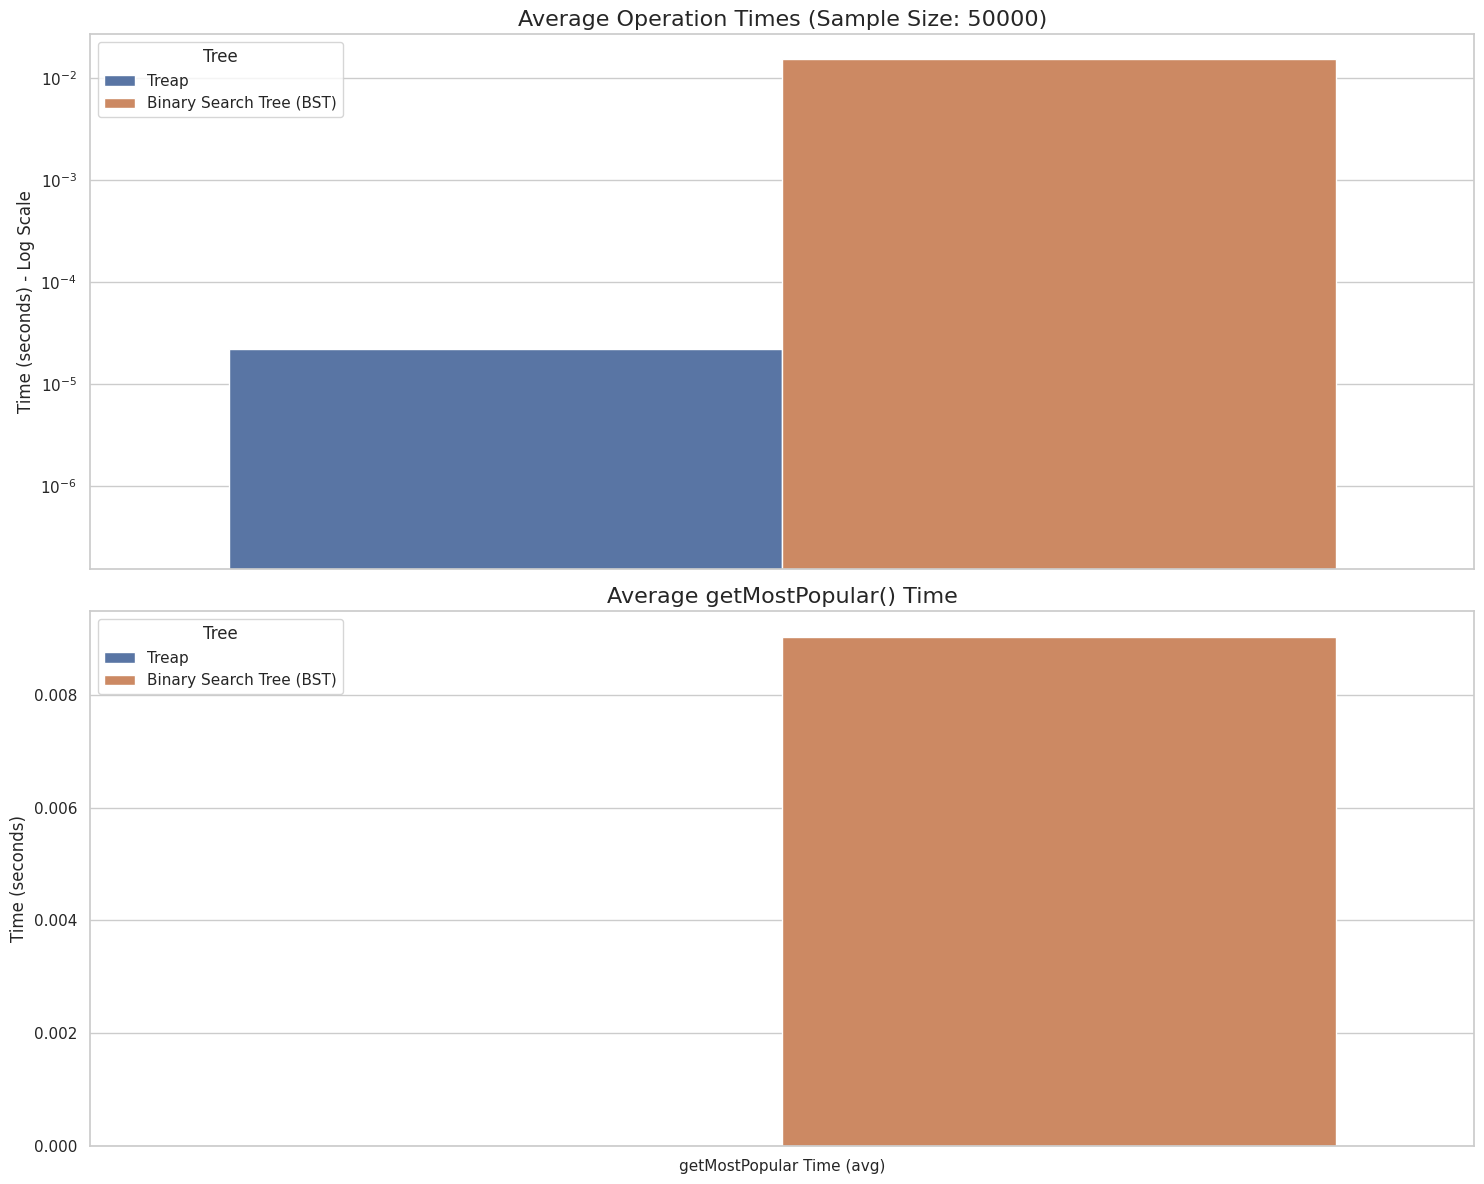

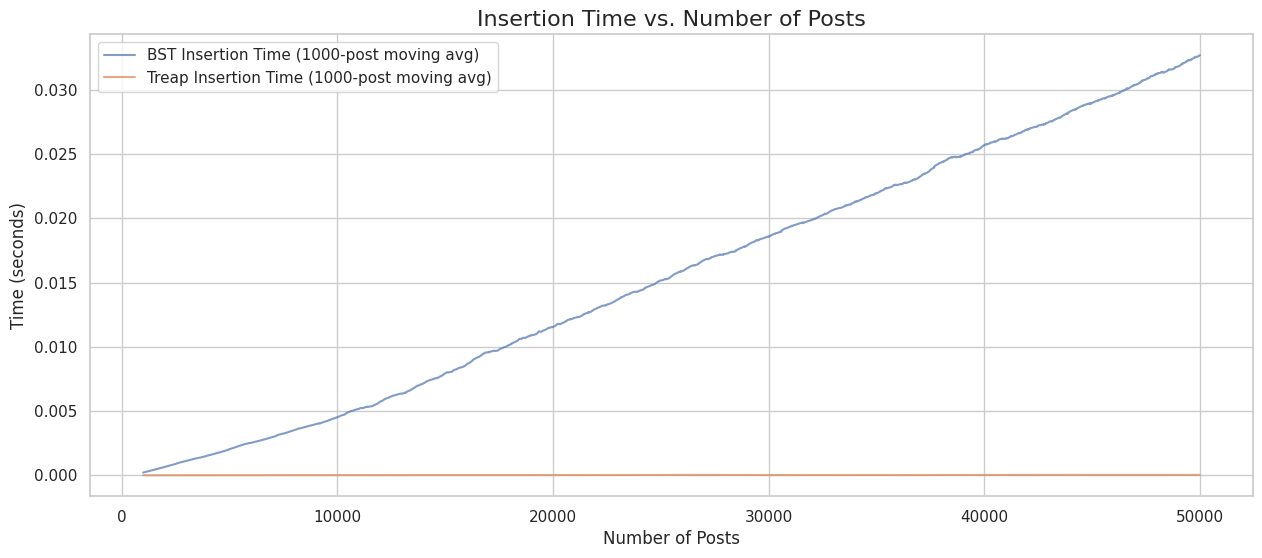

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


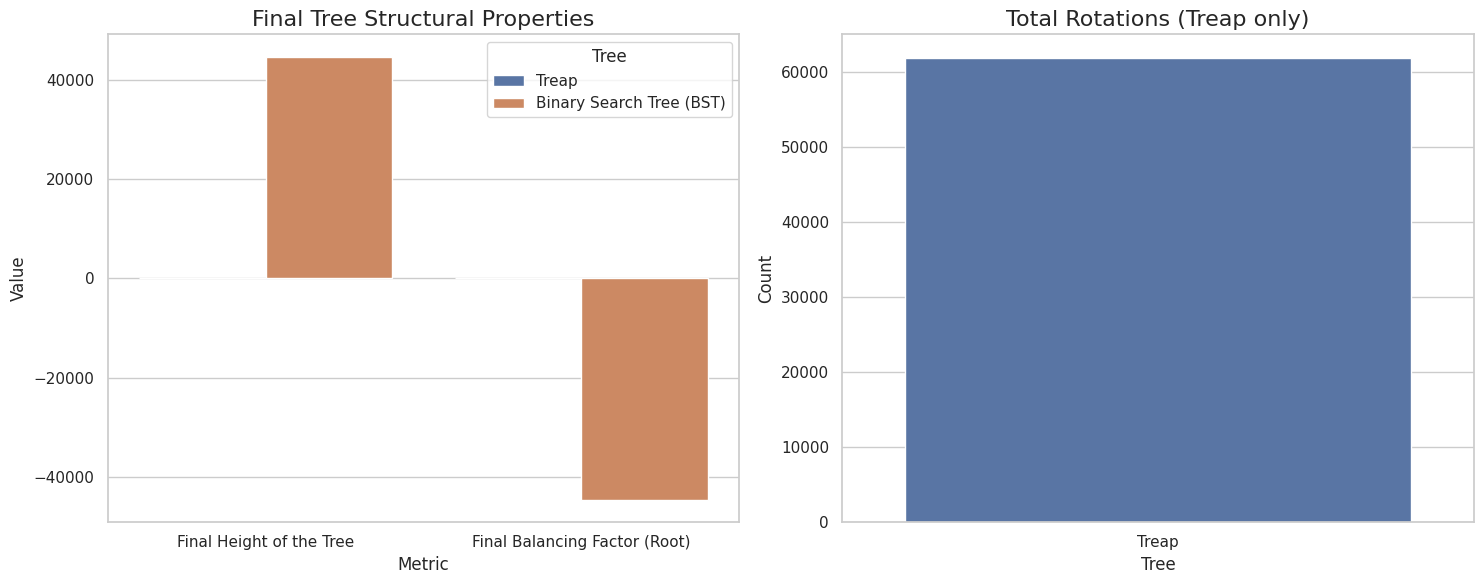

In [7]:
# --- CORRECTED STEP 7: Comparison Dashboard Visualizations ---
# This assumes the previous cell (Step 6) has been run.

if 'bst' in locals() and 'treap' in locals() and 'metrics_df' in locals():
    print("Generating visualizations...")
    sns.set(style="whitegrid")
    
    # 1. Bar Chart: Average Operation Times
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    op_metrics = metrics_df[metrics_df['Metric'].isin([
        'Insertion Time (avg)', 
        'Deletion Time (avg)',
        'likePost Time (avg)',
        'Search Time (avg)'
    ])]
    
    # Melt for grouped bar plot
    op_metrics_melted = op_metrics.melt(id_vars='Metric', var_name='Tree', value_name='Time (seconds)')
    
    sns.barplot(x='Metric', y='Time (seconds)', hue='Tree', data=op_metrics_melted, ax=ax1)
    ax1.set_title(f'Average Operation Times (Sample Size: {len(post_ids)})', fontsize=16)
    ax1.set_ylabel('Time (seconds) - Log Scale')
    ax1.set_xlabel('')
    ax1.set_yscale('log') # Use log scale as insertions can be much faster than deletes
    
    # 2. Bar Chart: getMostPopular (The Key Comparison)
    popular_metrics = metrics_df[metrics_df['Metric'] == 'getMostPopular Time (avg)']
    popular_metrics_melted = popular_metrics.melt(id_vars='Metric', var_name='Tree', value_name='Time (seconds)')
    
    # --- THIS IS THE CORRECTED LINE ---
    sns.barplot(x='Metric', y='Time (seconds)', hue='Tree', data=popular_metrics_melted, ax=ax2)
    # --- END OF FIX ---
    
    ax2.set_title('Average getMostPopular() Time', fontsize=16)
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xlabel('')
    
    plt.tight_layout()
    plt.show()

    # 3. Line Chart: Insertion Time vs. # Nodes
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # We plot a moving average to smooth the noise
    bst_insert_smooth = pd.Series(bst.metrics['addPost'].times).rolling(window=1000).mean()
    treap_insert_smooth = pd.Series(treap.metrics['addPost'].times).rolling(window=1000).mean()
    
    ax.plot(bst_insert_smooth, label='BST Insertion Time (1000-post moving avg)', alpha=0.7)
    ax.plot(treap_insert_smooth, label='Treap Insertion Time (1000-post moving avg)', alpha=0.7)
    ax.set_title('Insertion Time vs. Number of Posts', fontsize=16)
    ax.set_xlabel('Number of Posts')
    ax.set_ylabel('Time (seconds)')
    ax.legend()
    plt.show()

    # 4. Bar Chart: Final Height, Balance Factor, and Rotations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    final_metrics = metrics_df[metrics_df['Metric'].isin([
        'Final Height of the Tree',
        'Final Balancing Factor (Root)'
    ])]
    final_metrics_melted = final_metrics.melt(id_vars='Metric', var_name='Tree', value_name='Value')
    
    sns.barplot(x='Metric', y='Value', hue='Tree', data=final_metrics_melted, ax=ax1)
    ax1.set_title('Final Tree Structural Properties', fontsize=16)
    ax1.set_ylabel('Value')
    
    # Rotations
    rotations_metric = metrics_df[metrics_df['Metric'] == 'Total Rotations']
    rotations_melted = rotations_metric.melt(id_vars='Metric', var_name='Tree', value_name='Count')
    # Only plot Treap, as BST is 0
    sns.barplot(x='Tree', y='Count', data=rotations_melted[rotations_melted['Tree'] == 'Treap'], ax=ax2)
    ax2.set_title('Total Rotations (Treap only)', fontsize=16)
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

else:
    print("Please run Step 6 (Experiment Runner) first.")